# Homework 4: Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)

* $X\in\mathbb{R}^{N}$
* $\Phi\in\mathbb{R}^{N\times K}$
* $\theta_{true}=(1,1,\ldots,1)^T\in\mathbb{R}^{K}$
* $Y=\Phi(X)\theta_{true}+e$ where $e\sim\mathcal{N}(0,\sigma^2 I)$
* $\mathbb{D}=\left\{X,Y\right\}$


In [653]:
import numpy as np
from numpy.linalg import norm, inv
import matplotlib.pyplot as plt
from enum import Enum

def mle(theta, Phi_X, Y):
    return 0.5 * norm(Phi_X @ theta - Y, 2) ** 2

def mle_normal_equations(Phi_X, Y):
    return inv(Phi_X.T @ Phi_X) @ Phi_X.T @ Y

def grad_mle(theta, Phi_X, Y):
    return Phi_X.T @ (Phi_X @ theta - Y)

def map(theta, Phi_X, Y, lmb):
    return 0.5 * norm(Phi_X @ theta - Y, 2) ** 2 + 0.5 * lmb * norm(theta,) ** 2
    
def map_normal_equations(Phi_X, Y, lmb):
    M = Phi_X.shape[1]
    return inv(Phi_X.T @ Phi_X + lmb * np.identity(M)) @ Phi_X.T @ Y

def grad_map(theta, Phi_X, Y, lmb):
    return Phi_X.T @ (Phi_X @ theta - Y) + lmb * theta

class Optimizer(Enum):
    NORMAL_EQUATIONS = 1
    GD = 2
    SGD = 3

def compute_mle(Phi_X, Y, optimizer, **kwargs):
    if optimizer == Optimizer.NORMAL_EQUATIONS:
        return mle_normal_equations(Phi_X, Y)
    elif optimizer == Optimizer.SGD:
        theta_0 = np.zeros(Phi_X.shape[1])
        return sgd(grad_mle, theta_0, (Phi_X, Y), **kwargs)
    elif optimizer == Optimizer.GD:
        theta_0 = np.random.normal(size=(Phi_X.shape[1]))
        return gd(grad_mle, theta_0, (Phi_X, Y), **kwargs)
    else:
        raise ValueError("Unknown optimizer")

def compute_map(Phi_X, Y, optimizer, lmb, **kwargs):
    if optimizer == Optimizer.NORMAL_EQUATIONS:
        return map_normal_equations(Phi_X, Y, lmb)
    elif optimizer == Optimizer.SGD:
        theta_0 = np.random.normal(size=(Phi_X.shape[1]))
        return sgd(lambda theta, Phi_X, Y: grad_map(theta, Phi_X, Y, lmb), theta_0, (Phi_X, Y), **kwargs)
    elif optimizer == Optimizer.GD:
        theta_0 = np.zeros(Phi_X.shape[1])
        return gd(lambda theta, Phi_X, Y: grad_map(theta, Phi_X, Y, lmb), theta_0, (Phi_X, Y), **kwargs)
    else:
        raise ValueError("Unknown optimizer")

def gd(grad_l, w0, D, a = 0.01, kmax = 1000, tolf = 1e-6, tolx = 1e-6):
    X, Y = D 
    k = 0
    w = [w0]
    err = [norm(grad_l(w[0], X, Y), 2)]
    
    condition = True
    while condition:
        grad = grad_l(w[-1], X, Y)
        w.append(w[-1] - a * grad) 
        err.append(norm(grad, 2))

        condition1 = err[-1] >= tolf * err[0]
        condition2 = norm(w[-1] - w[-2], 2) >= tolx 
        condition3 = k < kmax
        condition = condition1 and condition2 and condition3

        k += 1
        
    return w[-1]

def sgd(grad_l, w0, D, batch_size=512, n_epochs=5, a=0.001, seed=42):
    X, Y = D 
    N = X.shape[0]
    w = np.copy(w0)

    for epoch in range(n_epochs):
        indices = np.arange(N)
        
        np.random.seed(seed)
        np.random.shuffle(indices)

        for i in range(0, N, batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = X[batch_indices]
            Y_batch = Y[batch_indices]
            grad = grad_l(w, X_batch, Y_batch)
            w = w - a * grad
 
    return w

def make_dataset(K, N, a, b, sigma, seed=None):
    if seed is not None:
        np.random.seed(seed)  
        
    theta_true = np.ones(K + 1)
    
    X = np.linspace(a, b, N)
    
    Phi_X = np.vander(X, K + 1, increasing=True)

    noise = np.random.normal(0, np.sqrt(sigma), N)

    Y = Phi_X @ theta_true + noise

    return (X, Y), theta_true

class MLE_Regressor:
    def __init__(self, K, optimizer):
        self.K = K + 1
        self.optimizer = optimizer

    def fit(self, X_train, Y_train):
        Phi_X_train = np.vander(X_train, self.K, increasing = True)
        self.theta_star = compute_mle(Phi_X_train, Y_train, self.optimizer)
        return self

    def __call__(self, X):
        Phi_X = np.vander(X, self.K, increasing = True)
        return Phi_X @ self.theta_star

    def average_absolute_error(self, X_test, Y_test):
        Phi_X_test = np.vander(X_test, self.K, increasing=True)
        N_test = X_test.shape[0]
        return mle(self.theta_star, Phi_X_test, Y_test) / N_test

    def err(self, theta_true):
        pad_length = len(self.theta_star) - len(theta_true)
        theta_true_padded = np.pad(theta_true, (0, pad_length), 'constant', constant_values=0)
        return norm(self.theta_star - theta_true_padded, 2) / norm(theta_true_padded, 2)

class MAP_Regressor(MLE_Regressor):
    def __init__(self, K, optimizer, lmb):
        super().__init__(K, optimizer)
        self.lmb = lmb

    def fit(self, X_train, Y_train):
        Phi_X_train = np.vander(X_train, self.K, increasing = True)
        self.theta_star = compute_map(Phi_X_train, Y_train, self.optimizer, self.lmb)
        return self

def plot_mle_regression(X_train, Y_train, X_test, Y_test, X_model, Y_model, K, N):
    plt.figure(figsize=(8,6))
    plt.scatter(X_train, Y_train, color='blue', alpha=0.3, label='Training data')
    plt.scatter(X_test, Y_test, color='red', alpha=0.3, label='Test data')
    plt.plot(X_model, Y_model, color='black', label=f'Model with K={K}')

    plt.title(f'MLE Regression with K={K} and N={N}')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.legend()
    plt.show()

def plot_map_regressions(X_train, Y_train, X_test, Y_test, X_model, Y_models, K, lambdas, N):
    plt.figure(figsize=(8,6))
    plt.scatter(X_train, Y_train, color='blue', alpha=0.3, label='Training data')
    plt.scatter(X_test, Y_test, color='red', alpha=0.3, label='Test data')

    for i, lambda_val in enumerate(lambdas):
        plt.plot(X_model, Y_models[i], label=f'Model with λ={lambda_val}')

    plt.title(f'MAP Regression with K={K} and N={N}')
    plt.xlabel('X')
    plt.ylabel('Y')

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    plt.legend()
    plt.show()

def plot_errors(K_values, train_errors, test_errors, N):
    plt.plot(K_values, train_errors, label='Training Error', marker='o')
    plt.plot(K_values, test_errors, label='Test Error', marker='o')
    
    plt.title(f'Training and Test Errors for different values of K with N={N}')
    plt.xlabel('Polynomial Degree K')
    plt.xticks(K_values)
    plt.ylabel('Average Absolute Error')
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

def plot_theta_errors(K_values, mle_theta_errors, map_theta_errors, lambdas, N):
    plt.figure(figsize=(12, 6))
    plt.plot(K_values, mle_theta_errors, label='MLE Error', marker='o')

    for i, lmb in enumerate(lambdas):
        plt.plot(K_values, map_theta_errors[i], label=f'MAP Error (λ={lmb})', marker='o')

    plt.title(f'Theta Errors for different values of K and $\\lambda$ with N={N}')
    plt.xlabel('Polynomial Degree K')
    plt.xticks(K_values)
    plt.yscale('log')
    plt.ylabel('Theta Error (log)')
    
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()

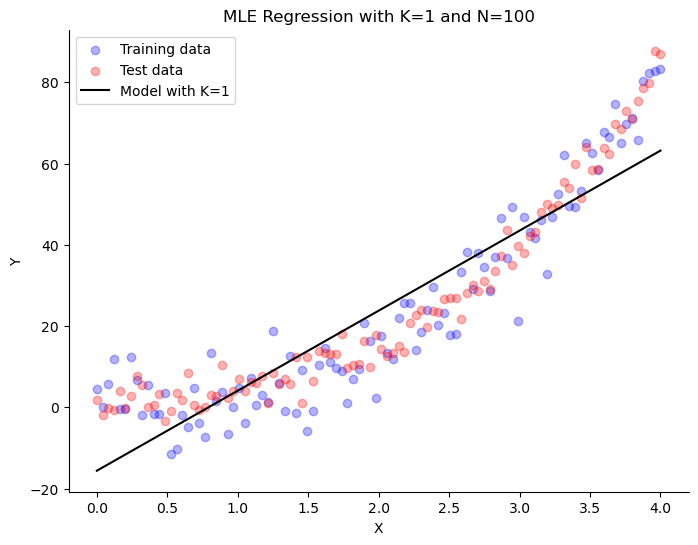

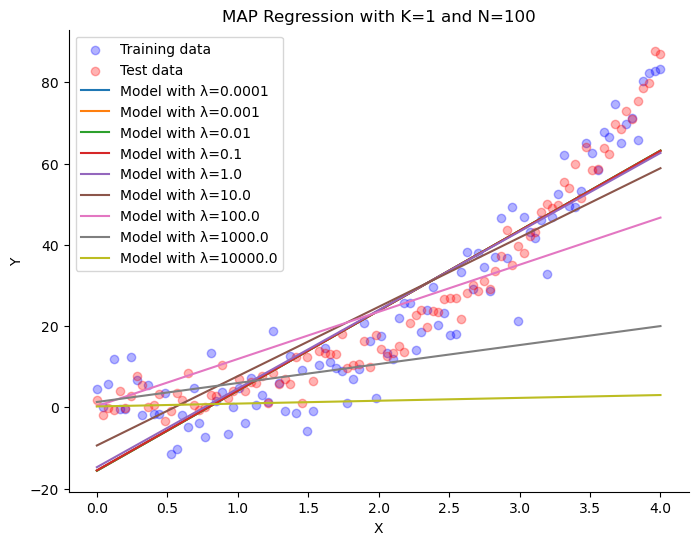

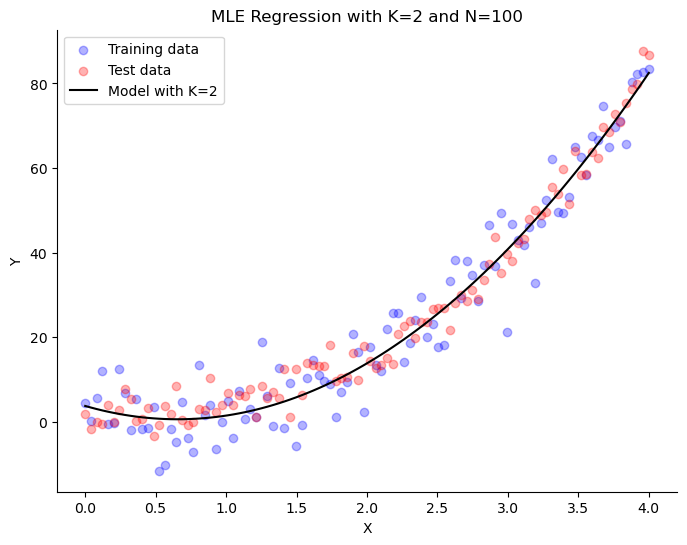

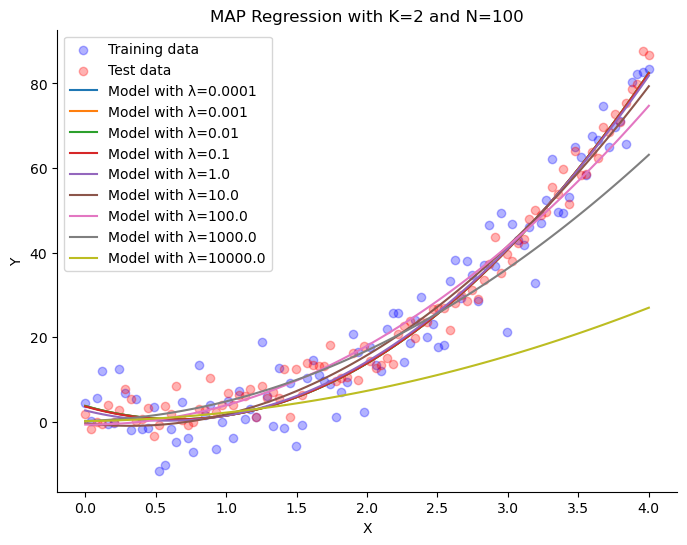

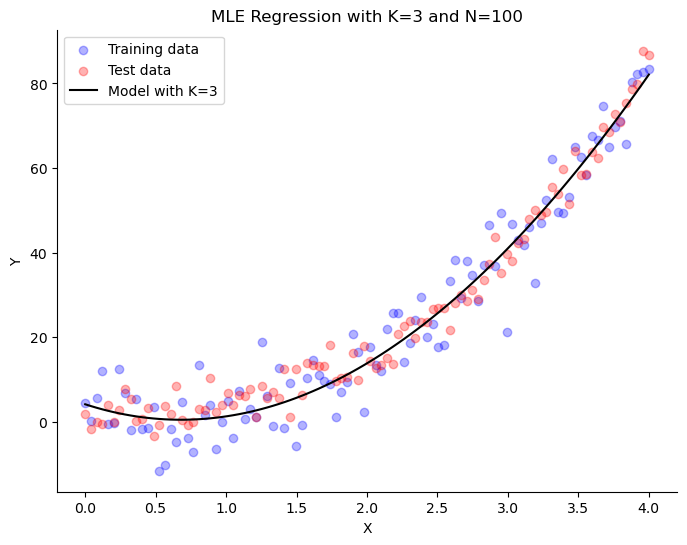

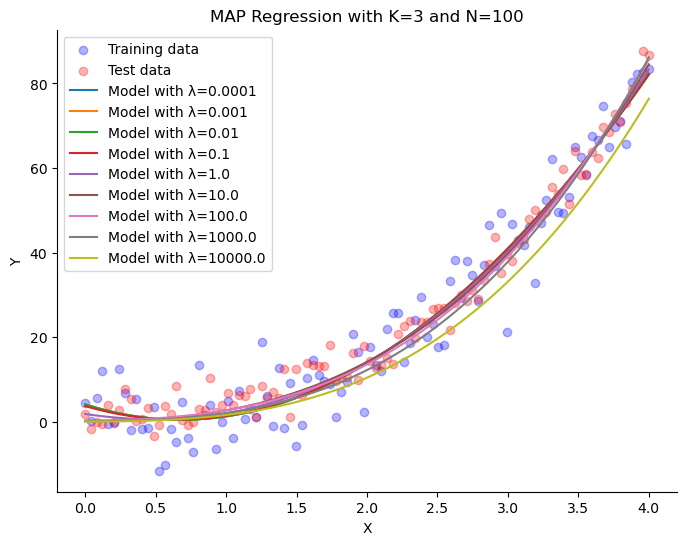

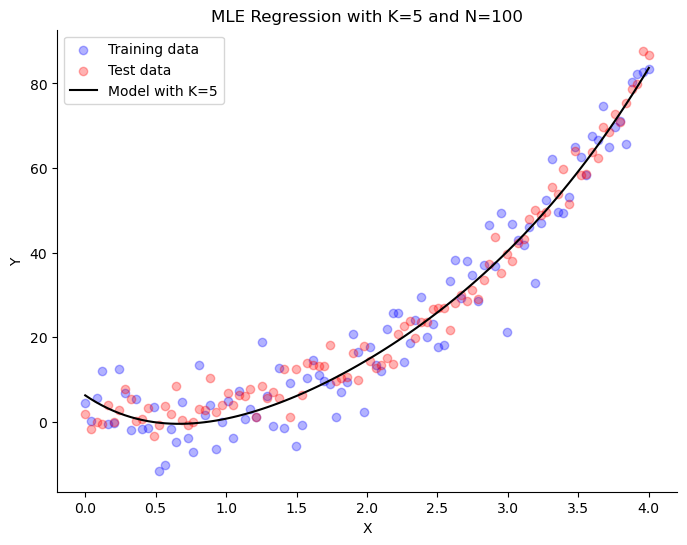

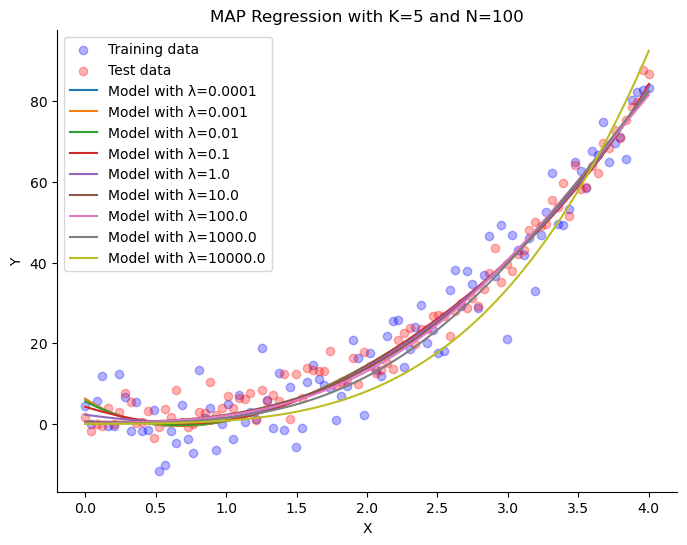

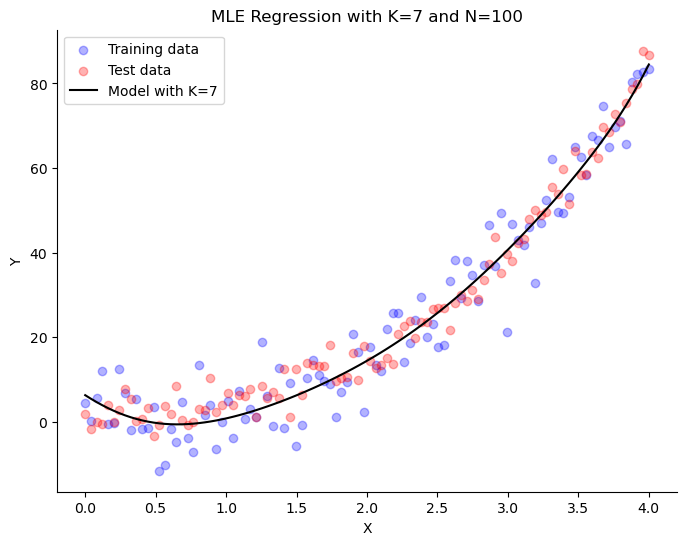

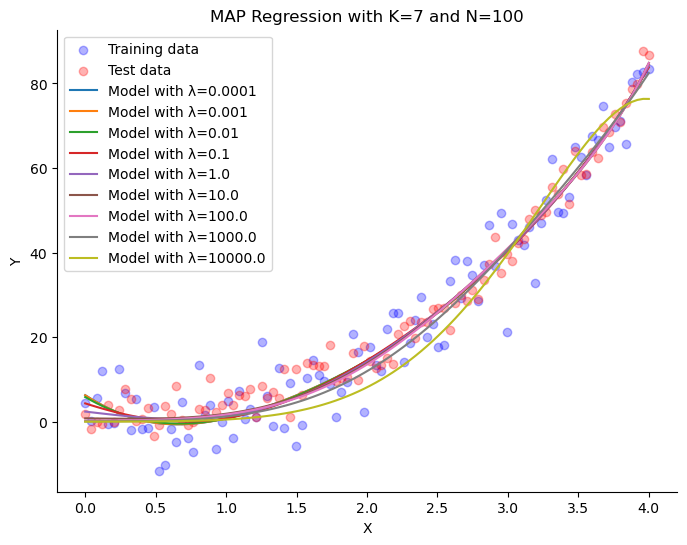

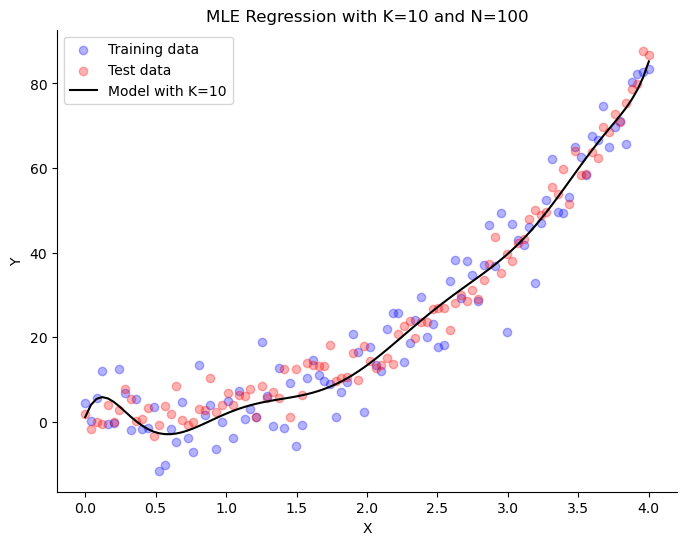

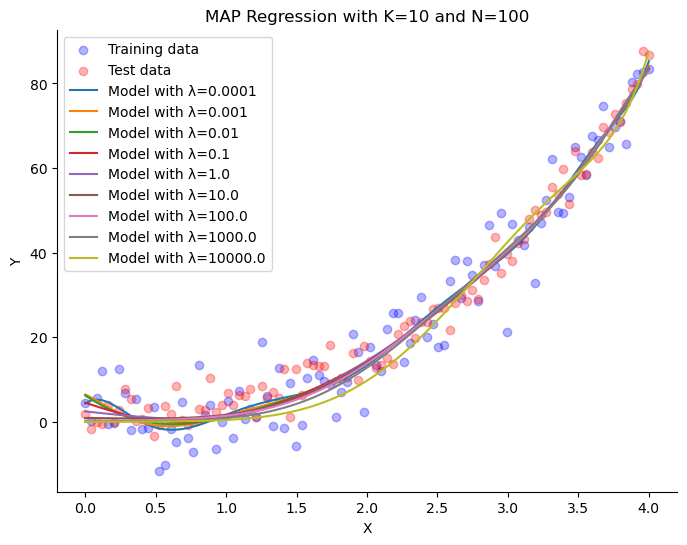

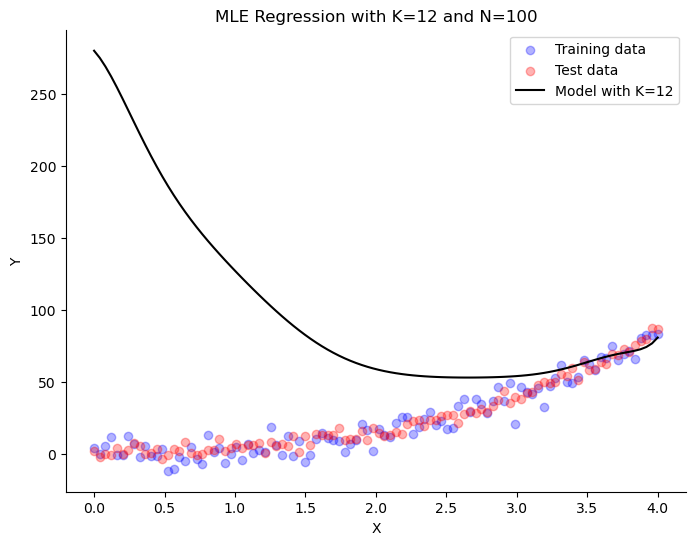

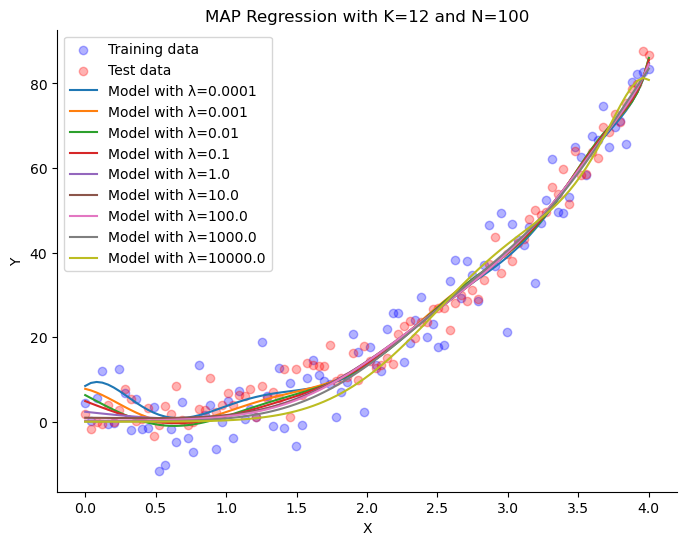

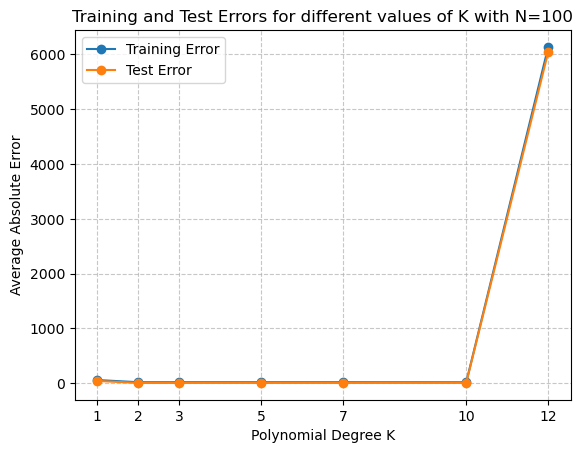

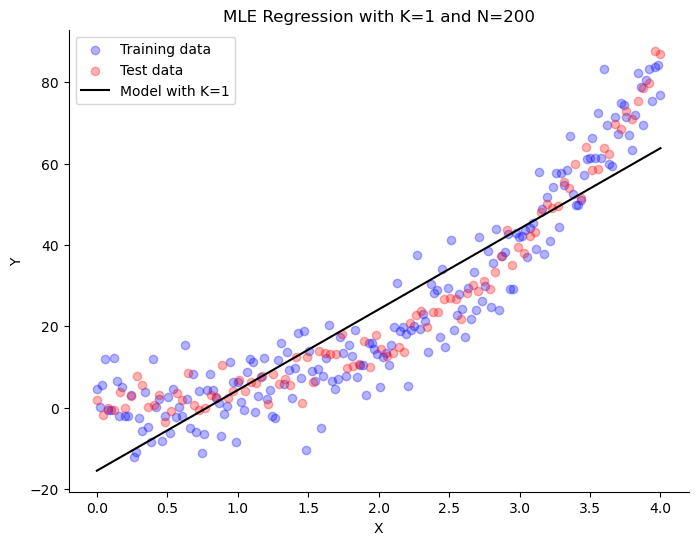

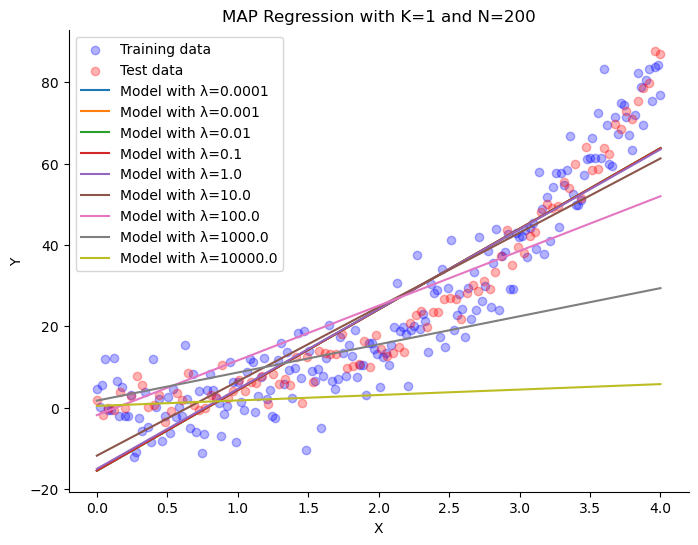

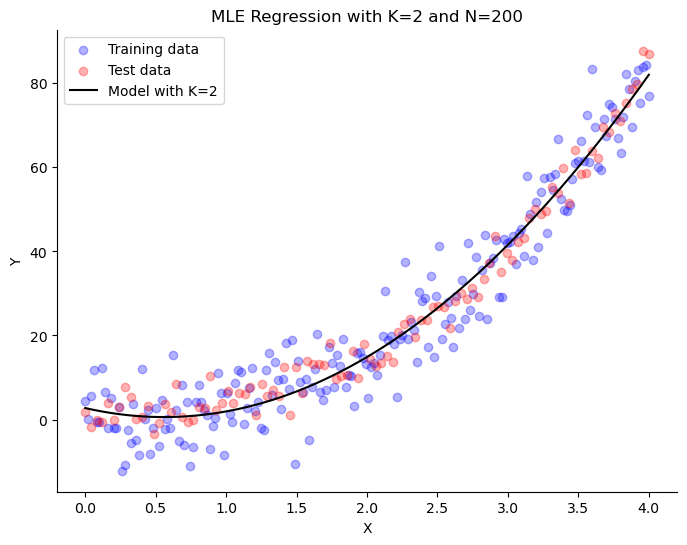

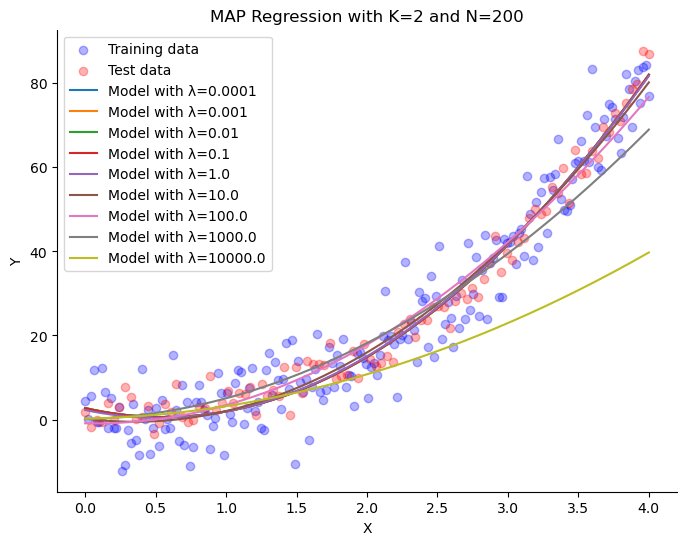

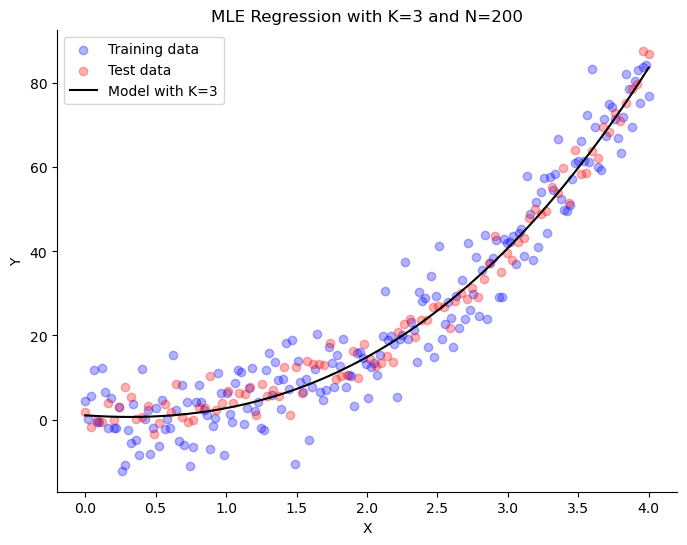

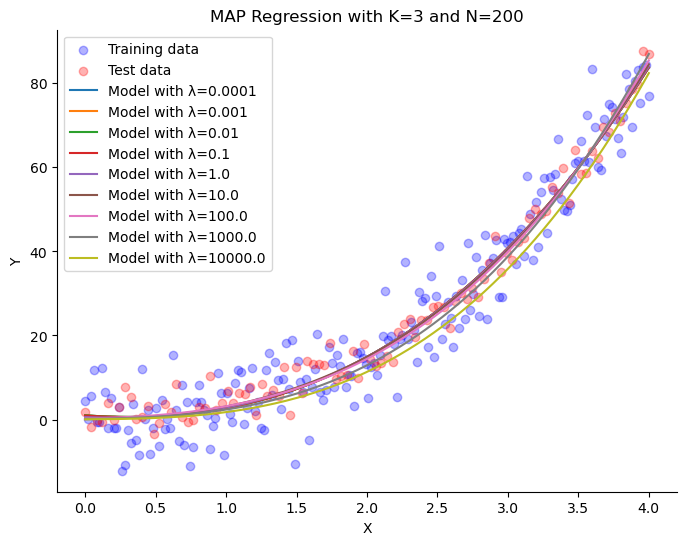

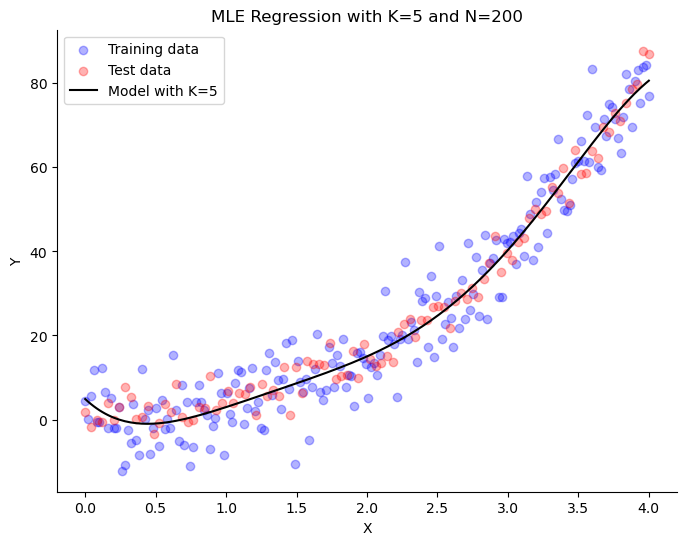

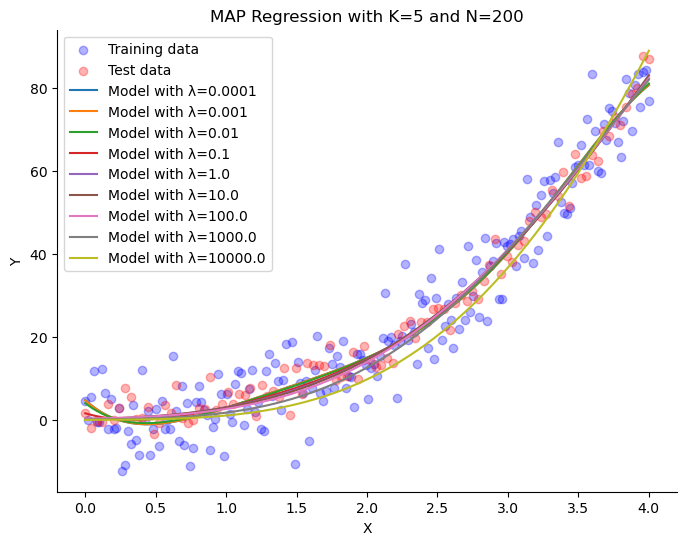

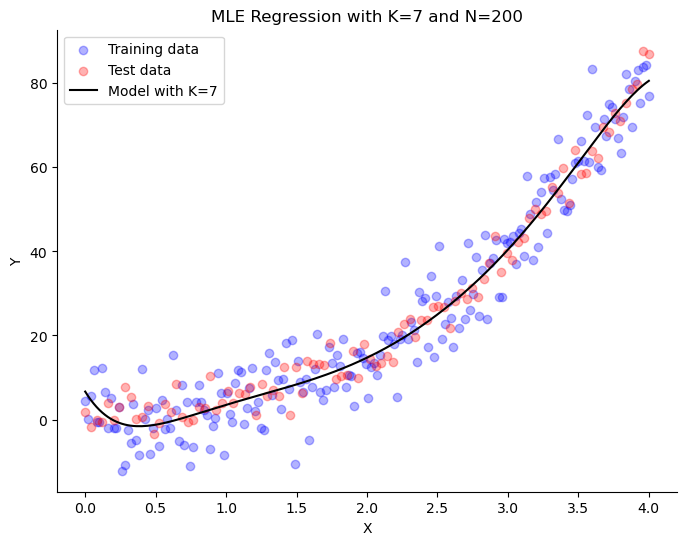

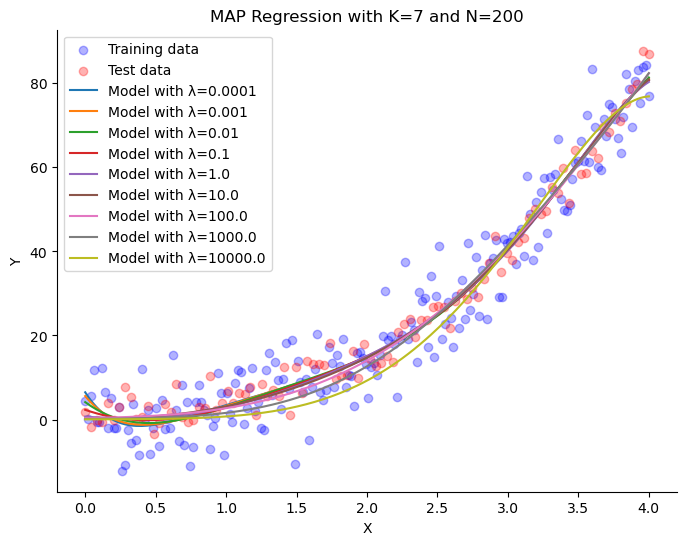

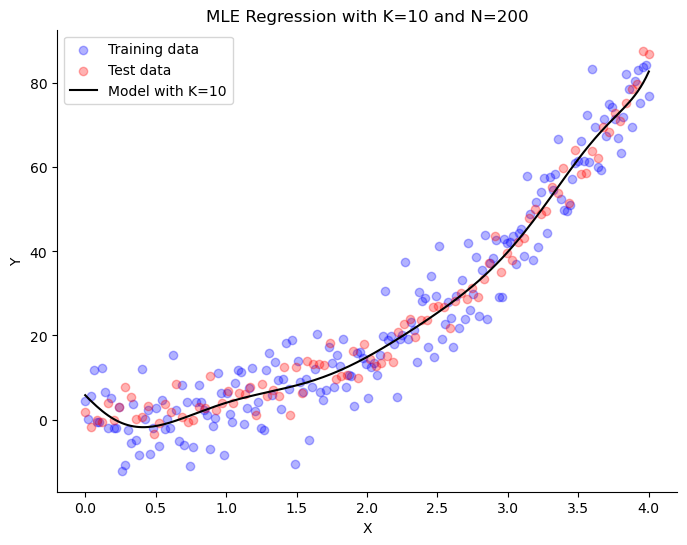

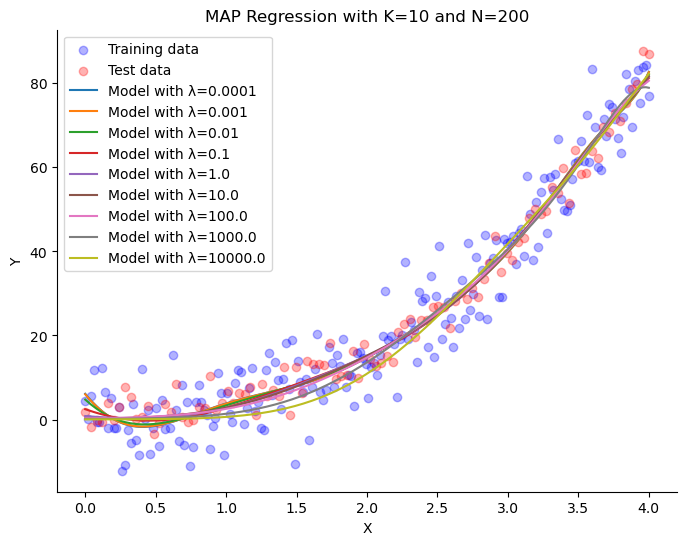

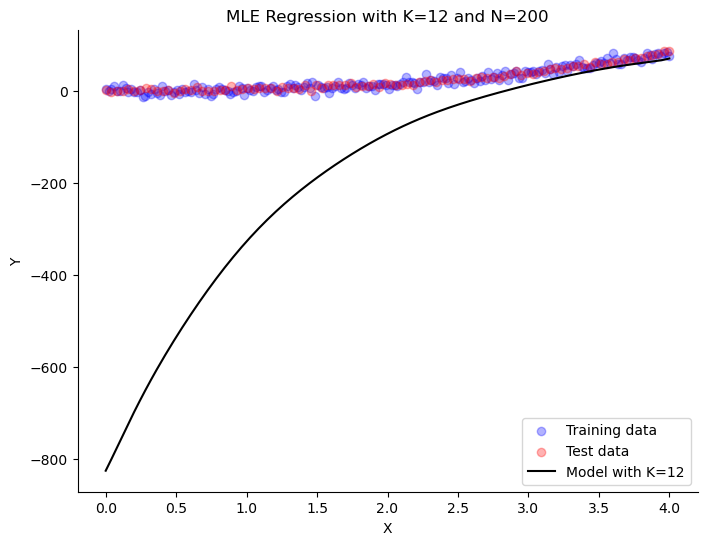

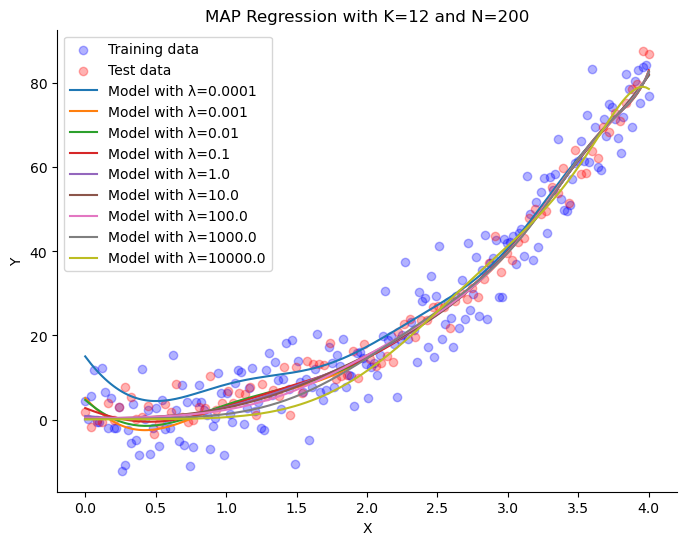

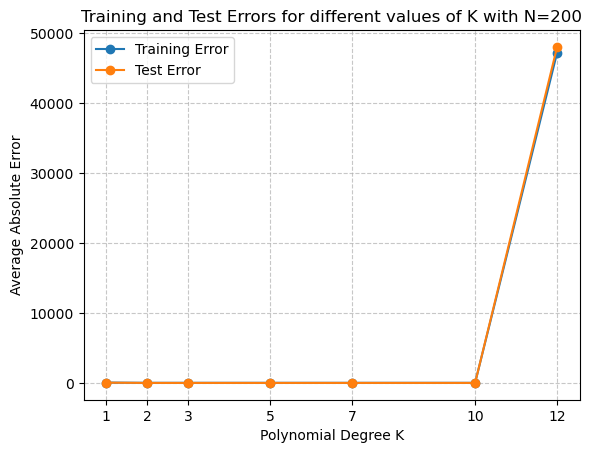

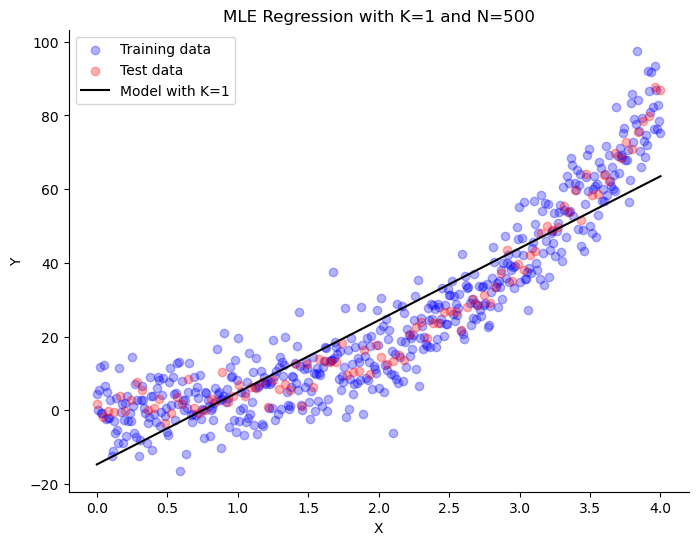

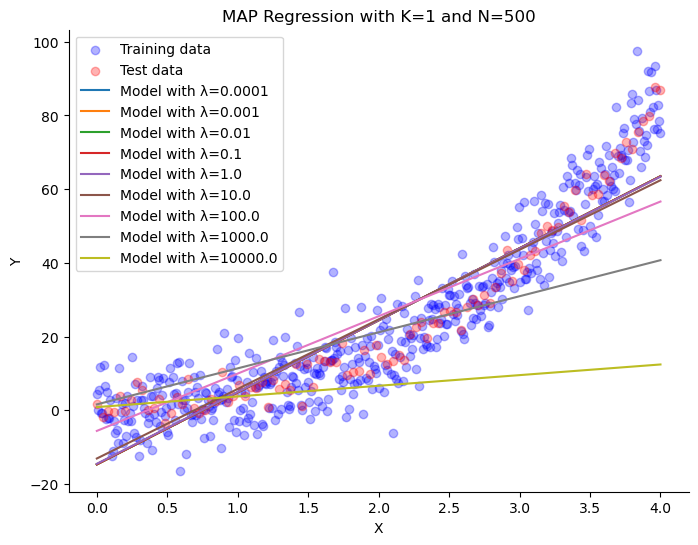

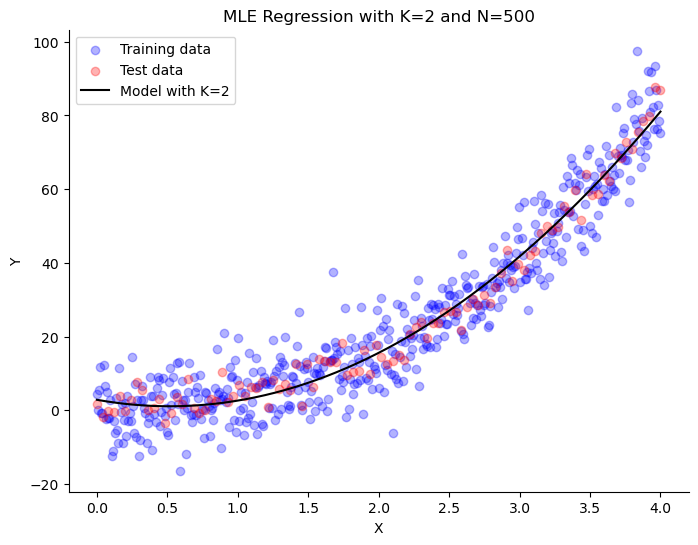

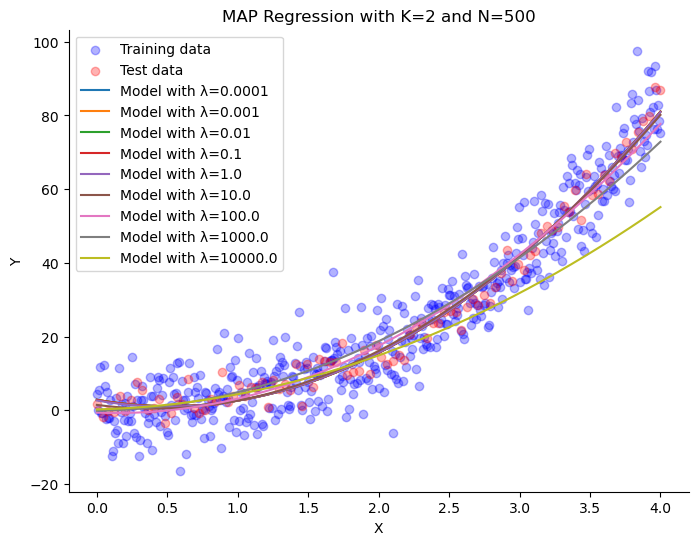

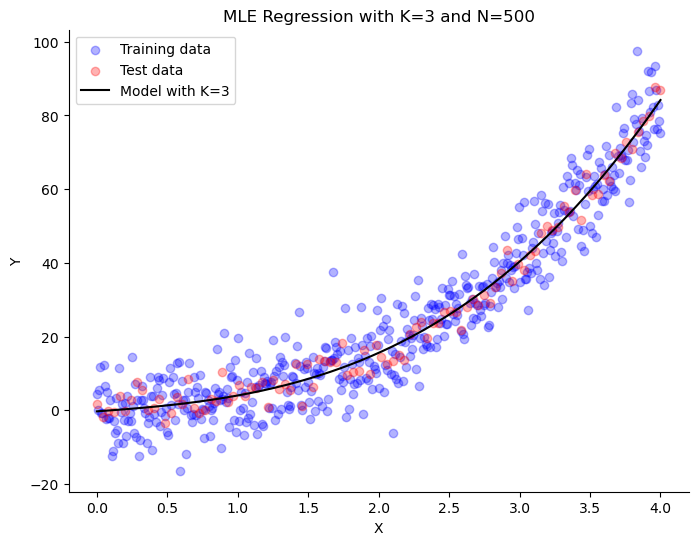

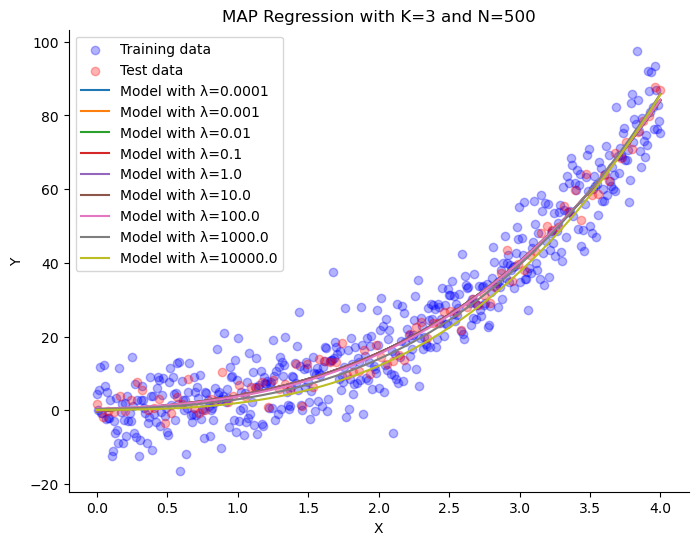

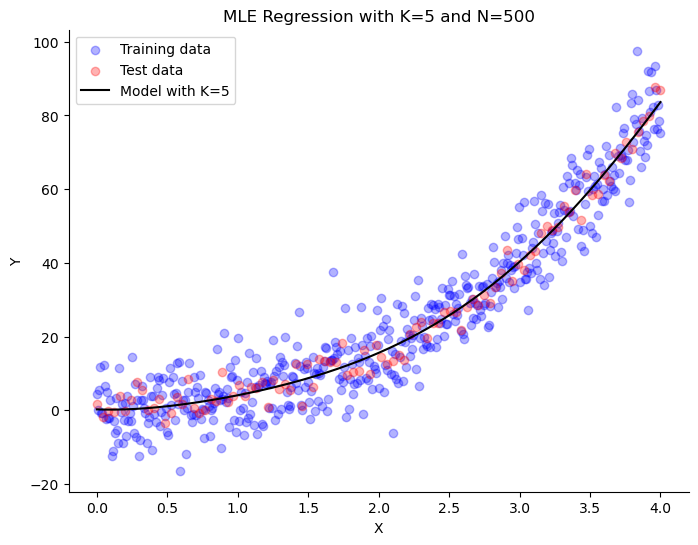

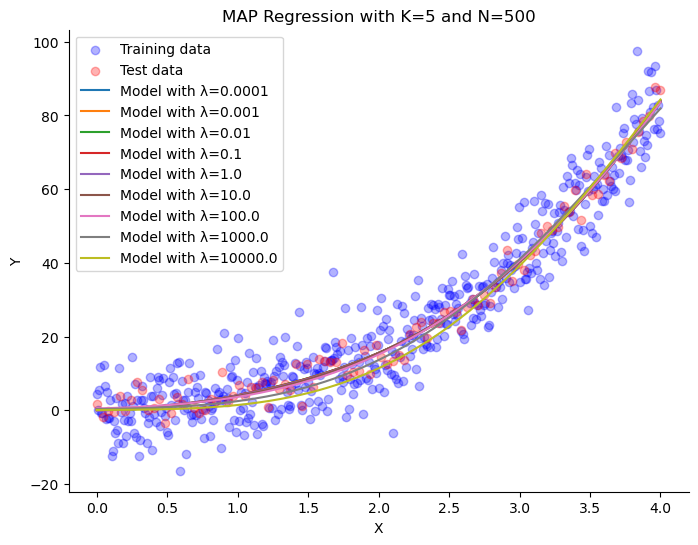

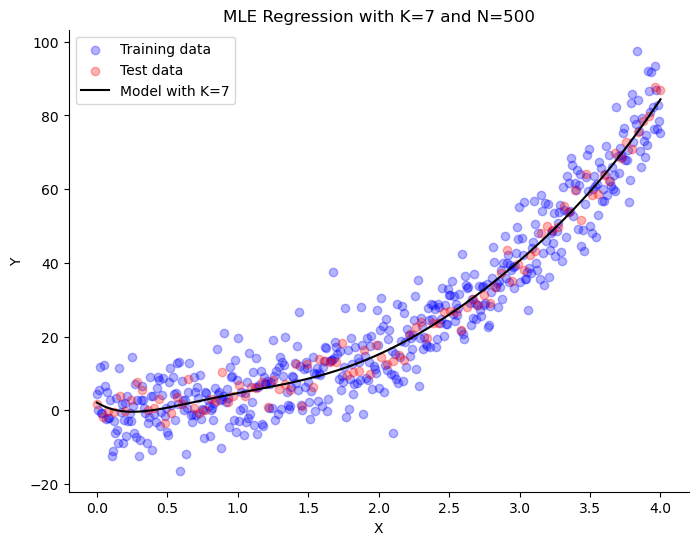

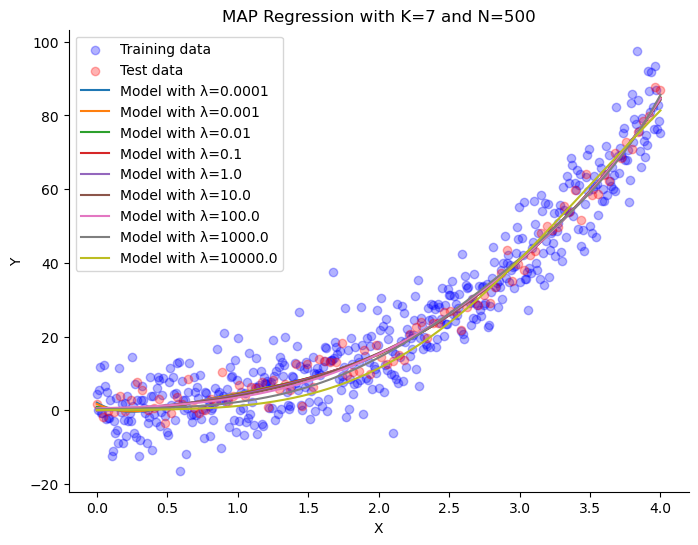

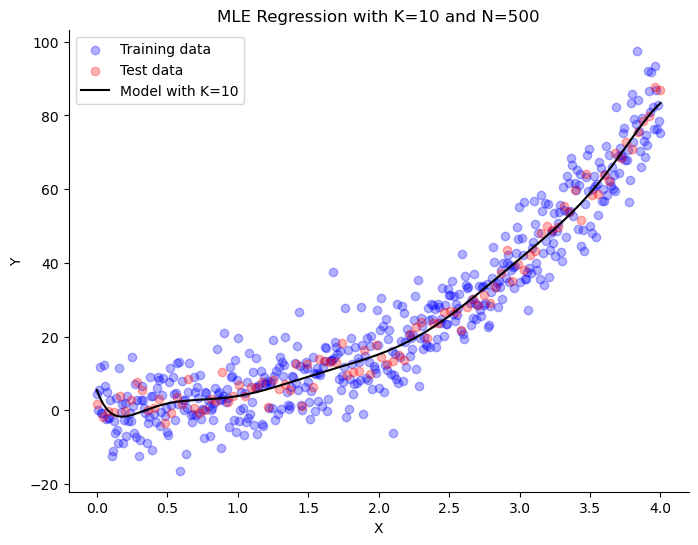

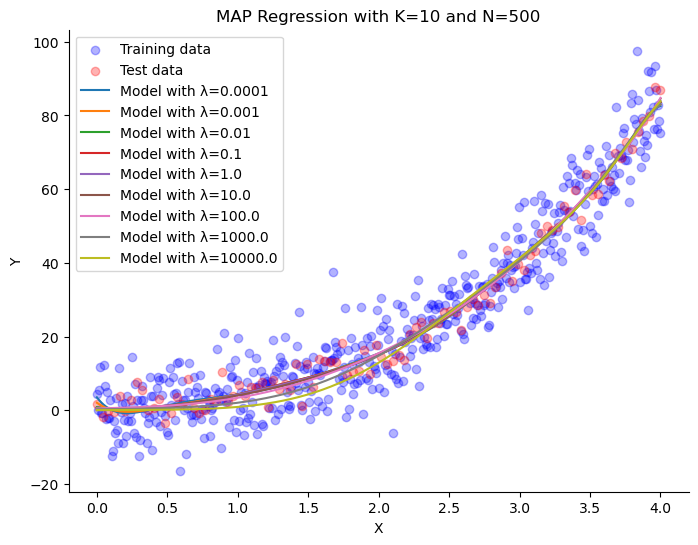

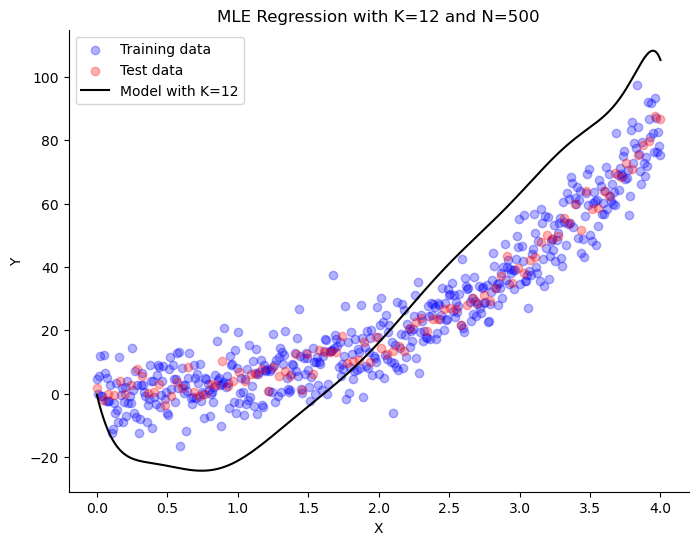

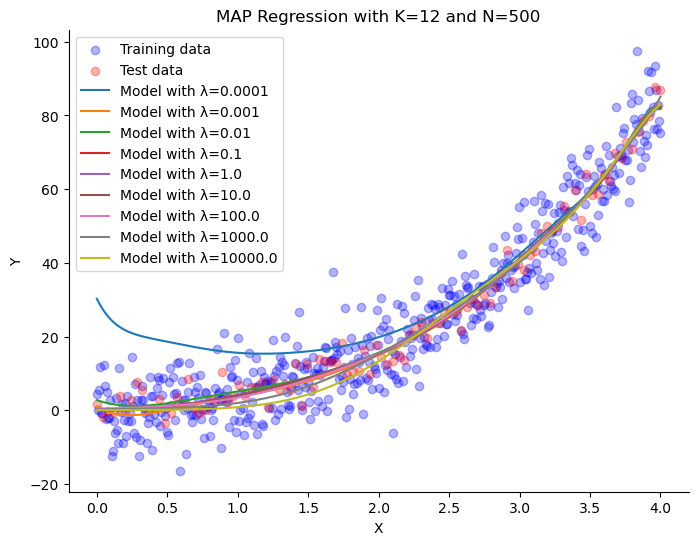

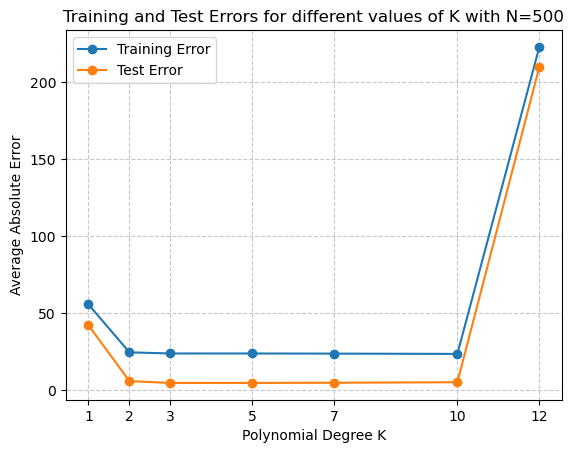

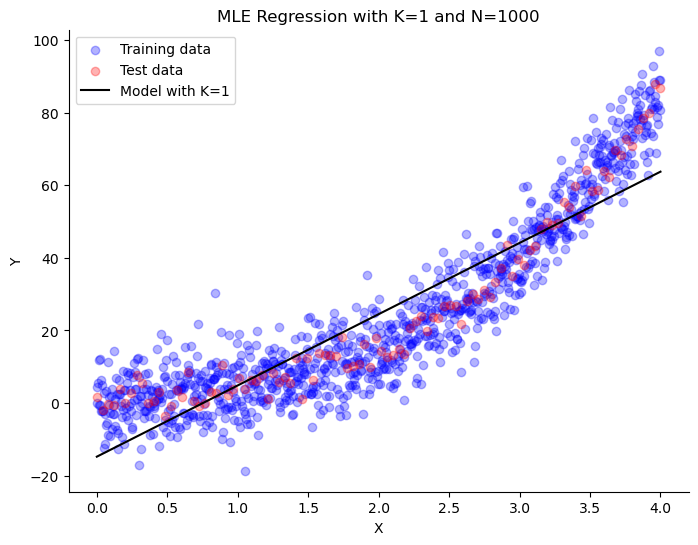

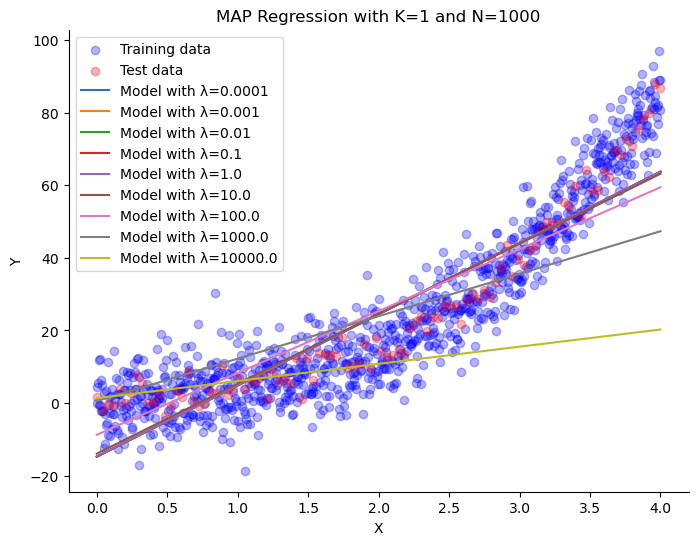

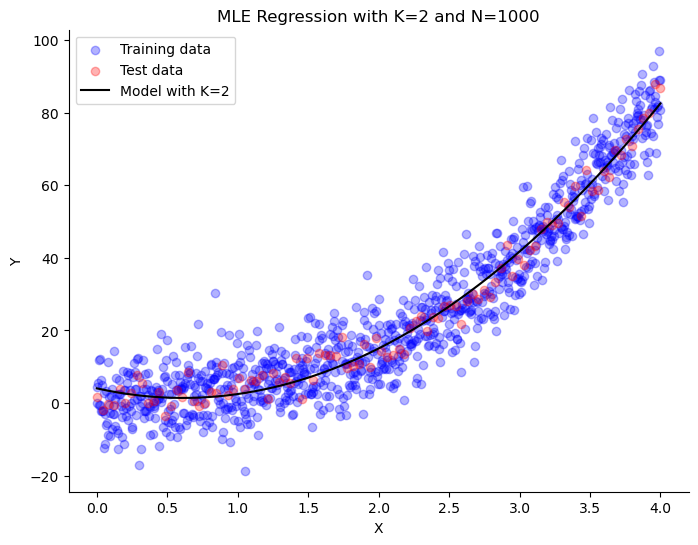

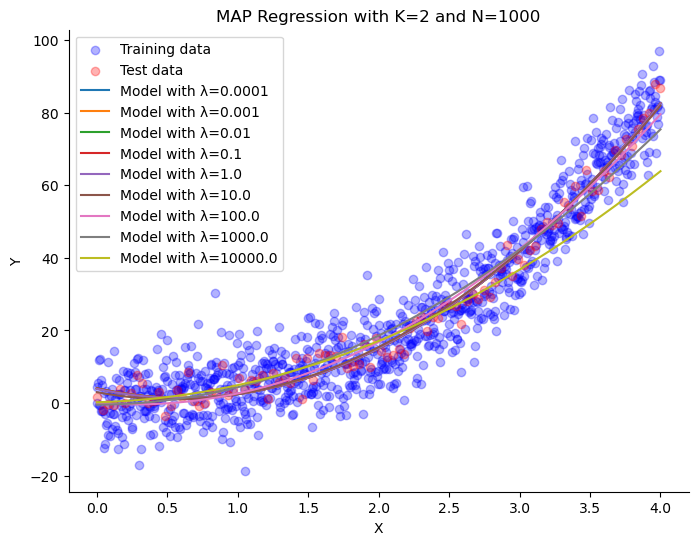

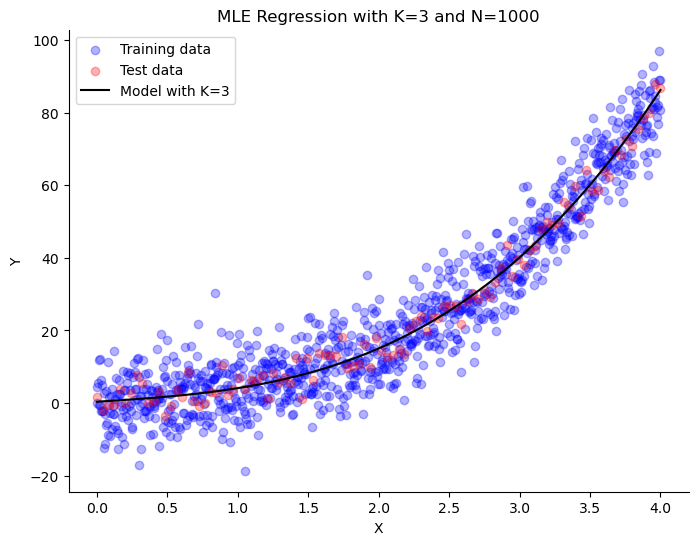

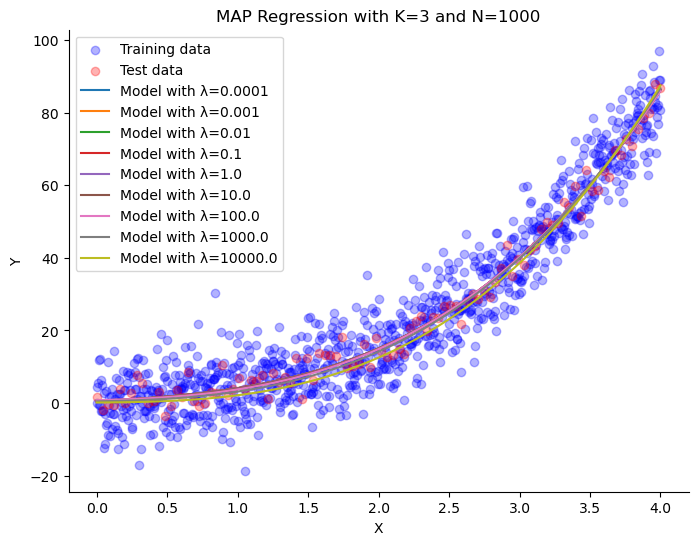

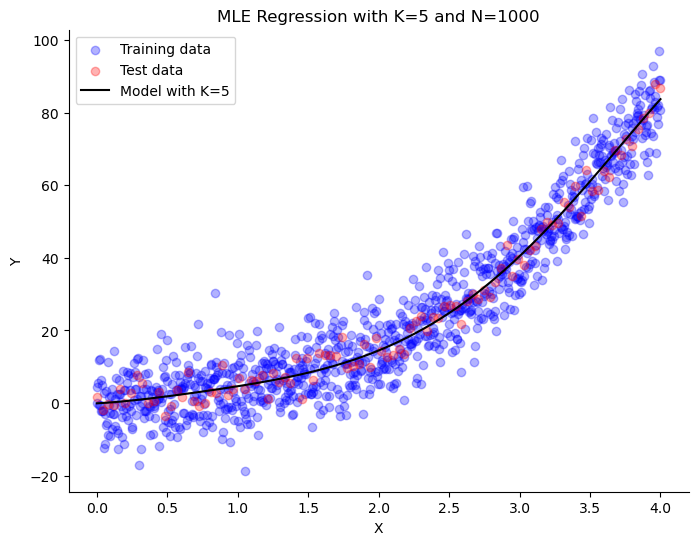

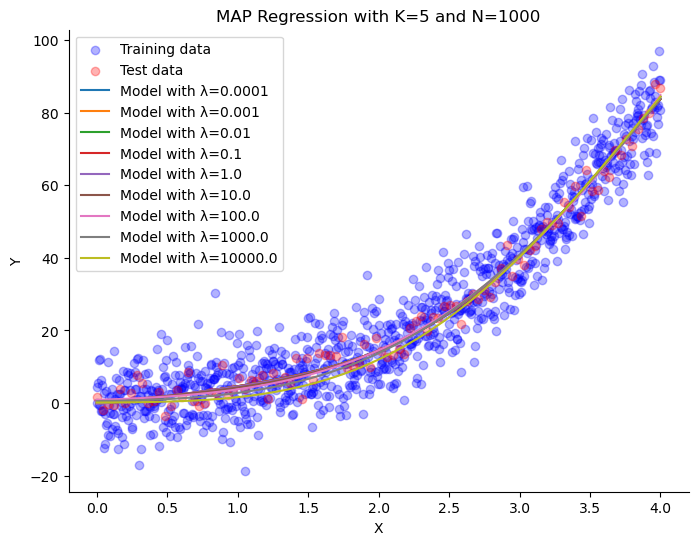

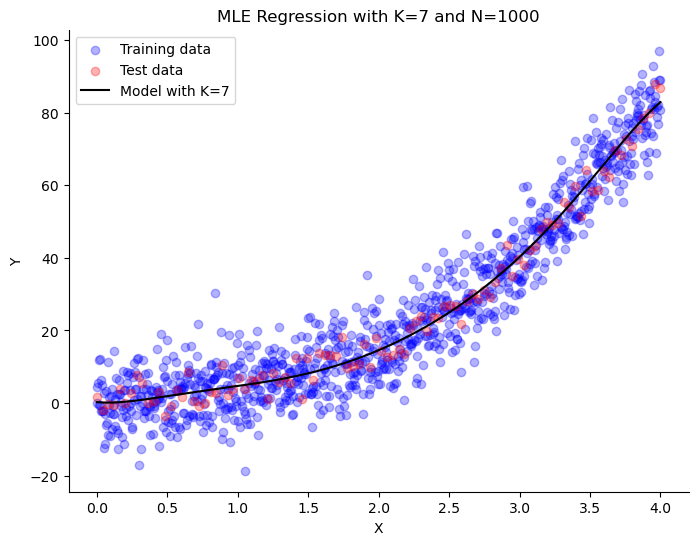

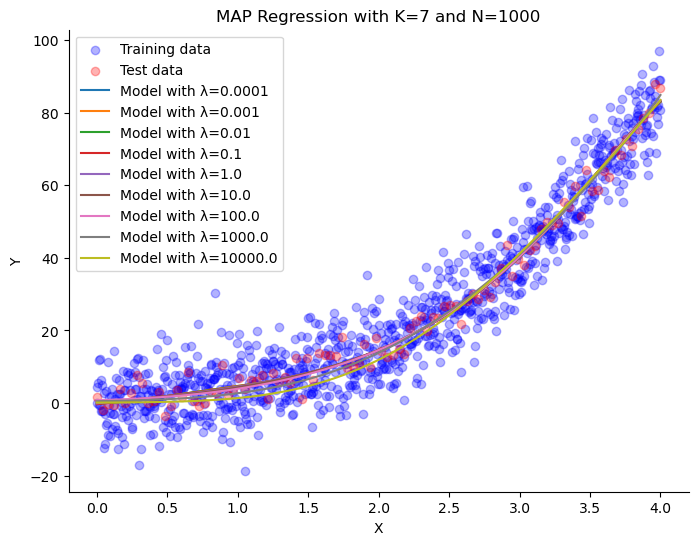

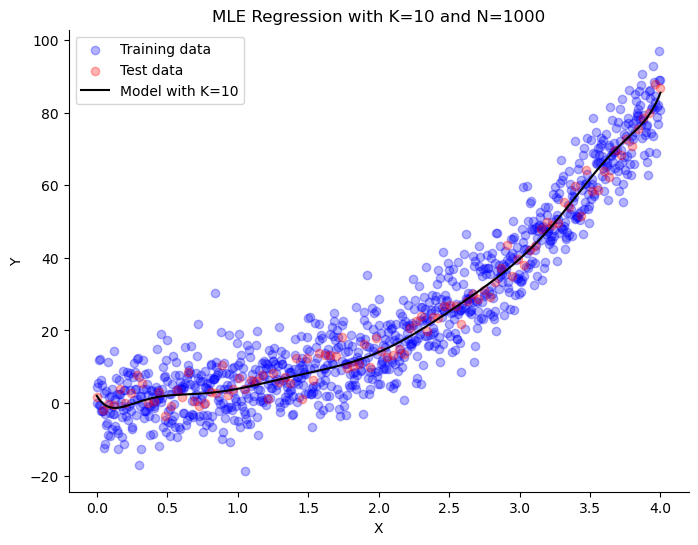

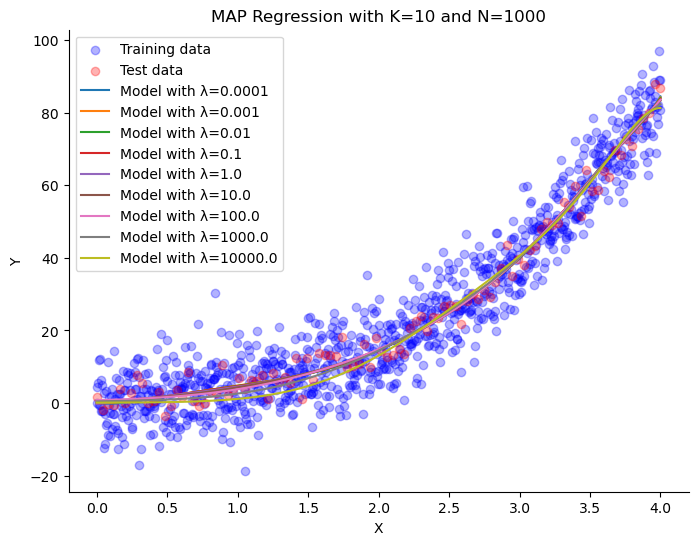

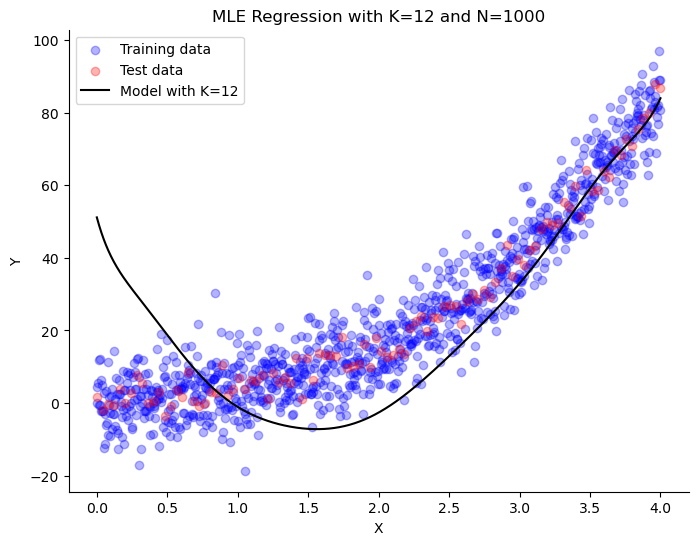

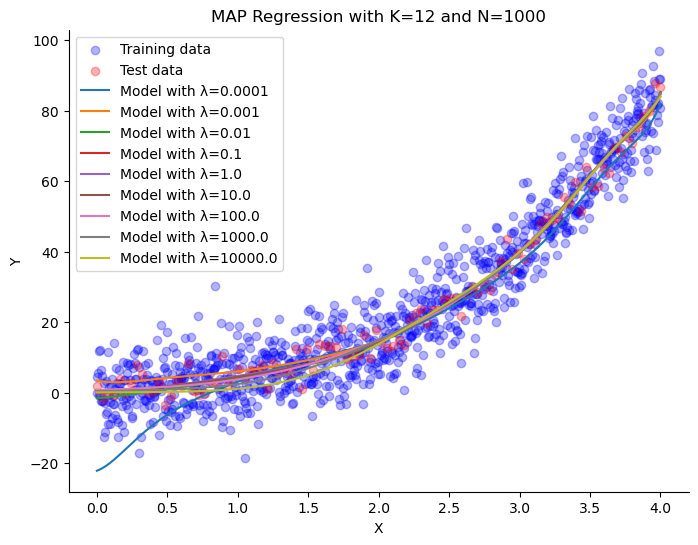

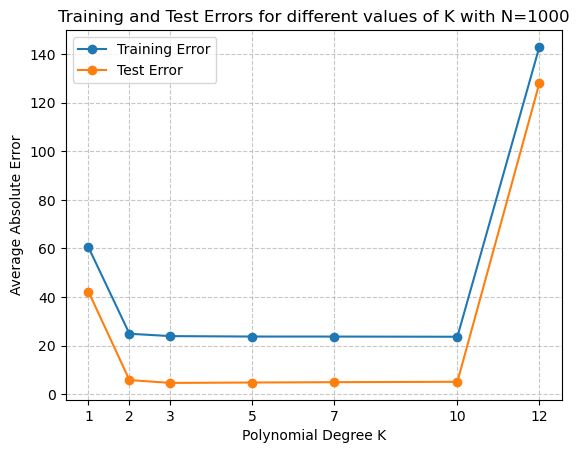

In [655]:
Ntest = 100
a = 0
b = 4
K_true = 3 
sigma_train = 50
sigma_test = 10
seed = 42

(X_test, Y_test), _ = make_dataset(K_true, Ntest, a, b, sigma_test, seed+1)

K_values = [1, 2, 3, 5, 7, 10, 12]
K_way_greater = 10
K_greater_values = [5, 7, 9, 11, 13, 15]
lambda_values = np.logspace(-4, 4, 9)
N_values = [100, 200, 500, 1000]

for N in N_values:
    (X_train, Y_train), theta_true = make_dataset(K_true, N, a, b, sigma_train, seed)
    for optimizer in [Optimizer.NORMAL_EQUATIONS]:
        train_errors = []
        test_errors = []
        for K in K_values:
            mle_model = MLE_Regressor(K, optimizer).fit(X_train, Y_train)
    
            Y_pred_train = mle_model(X_train)
            Y_pred_test = mle_model(X_test)
    
            train_errors.append(mle_model.average_absolute_error(X_train, Y_train))
            test_errors.append(mle_model.average_absolute_error(X_test, Y_test))
    
            Y_models = []
            for lmb in lambda_values:
                map_model = MAP_Regressor(K, optimizer, lmb).fit(X_train, Y_train)
                Y_models.append(map_model(X_train))
    
            plot_mle_regression(X_train, Y_train, X_test, Y_test, X_train, Y_pred_train, K, N)
            plot_map_regressions(X_train, Y_train, X_test, Y_test, X_train, Y_models, K, lambdas, N)
        plot_errors(K_values, train_errors, test_errors, N)

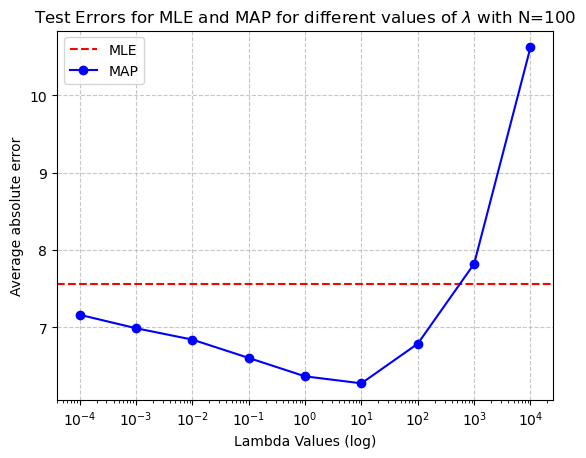

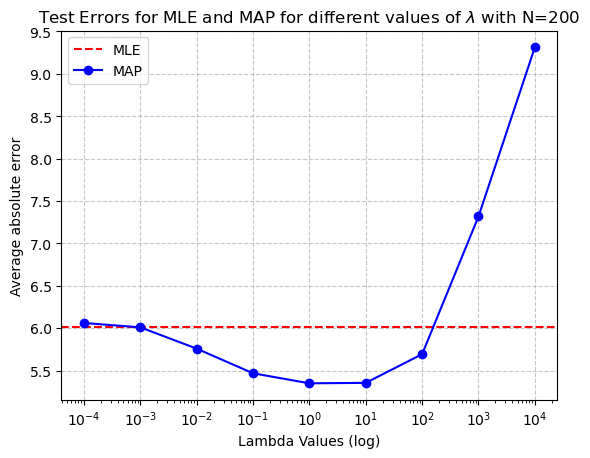

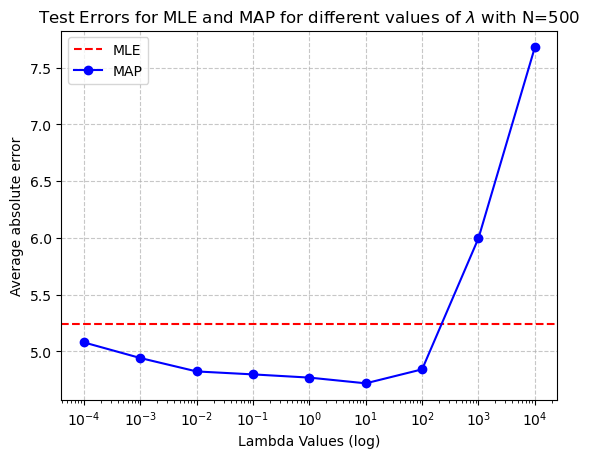

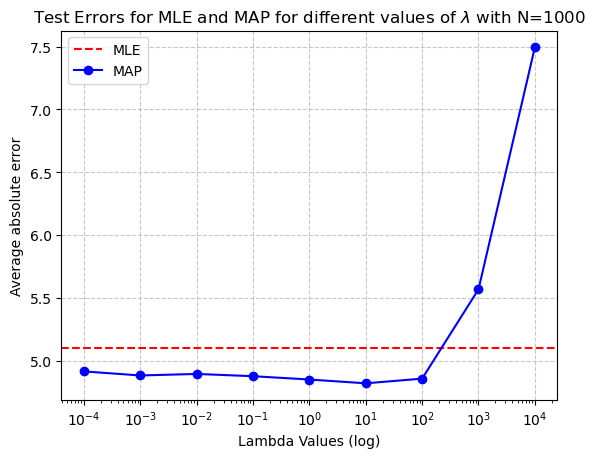

In [656]:
for N in N_values:
    (X_train, Y_train), theta_true = make_dataset(K_true, N, a, b, sigma_train, seed)
    for optimizer in [Optimizer.NORMAL_EQUATIONS]:
        mle_model = MLE_Regressor(K_way_greater, optimizer).fit(X_train, Y_train)
        mle_error = mle_model.average_absolute_error(X_test, Y_test)
        
        fig, ax = plt.subplots()
        ax.axhline(mle_error, label='MLE', color='red', linestyle='--')
    
        map_errors = []
        
        for lmb in lambda_values:
            map_model = MAP_Regressor(K_way_greater, optimizer, lmb).fit(X_train, Y_train)
            map_error = map_model.average_absolute_error(X_test, Y_test)
            map_errors.append(map_error)
        
        ax.plot(lambda_values, map_errors, label='MAP', color='blue', linestyle='-', marker='o')
        
        ax.set_title(f'Test Errors for MLE and MAP for different values of $\\lambda$ with N={N}')
        ax.set_xlabel('Lambda Values (log)')
        plt.xscale('log')
        ax.set_ylabel('Average absolute error')
    
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend()
        plt.show()

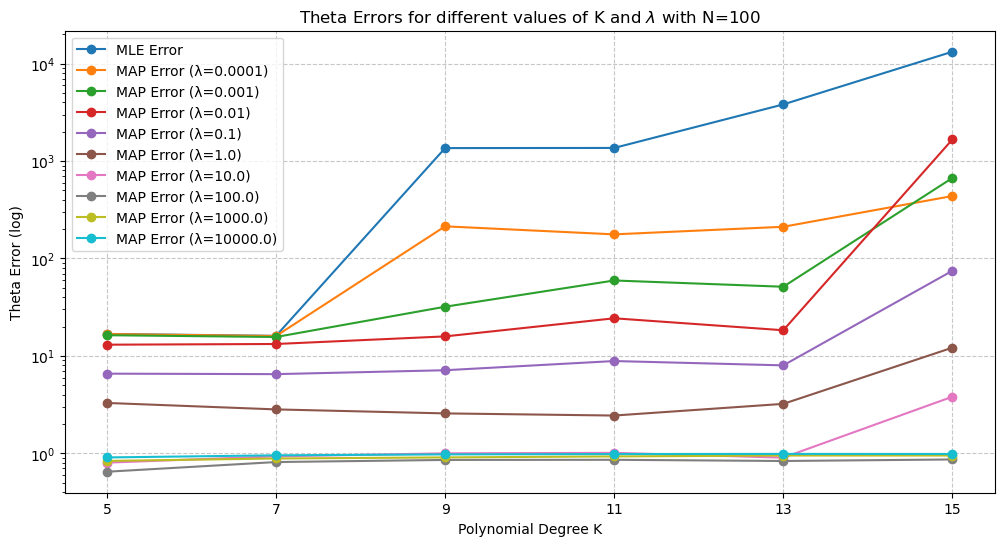

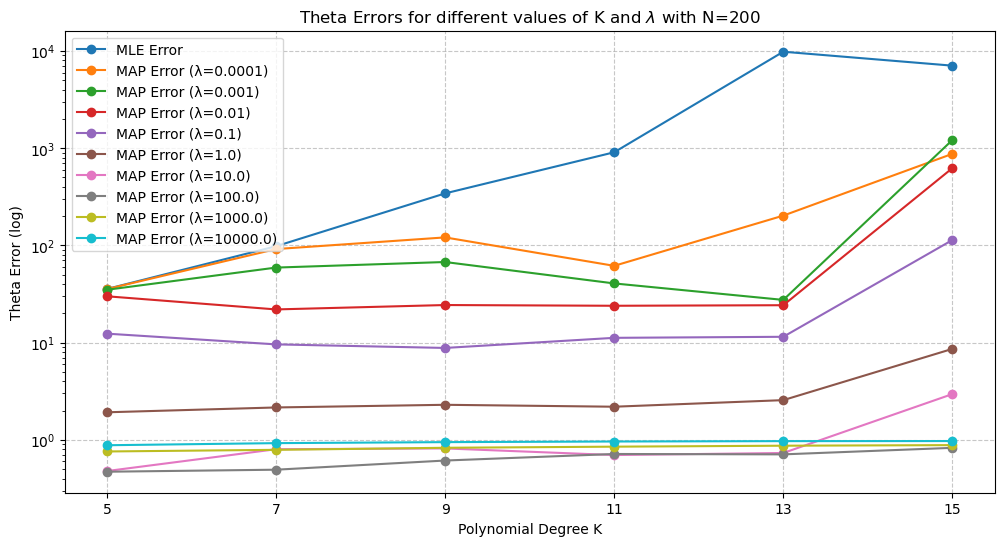

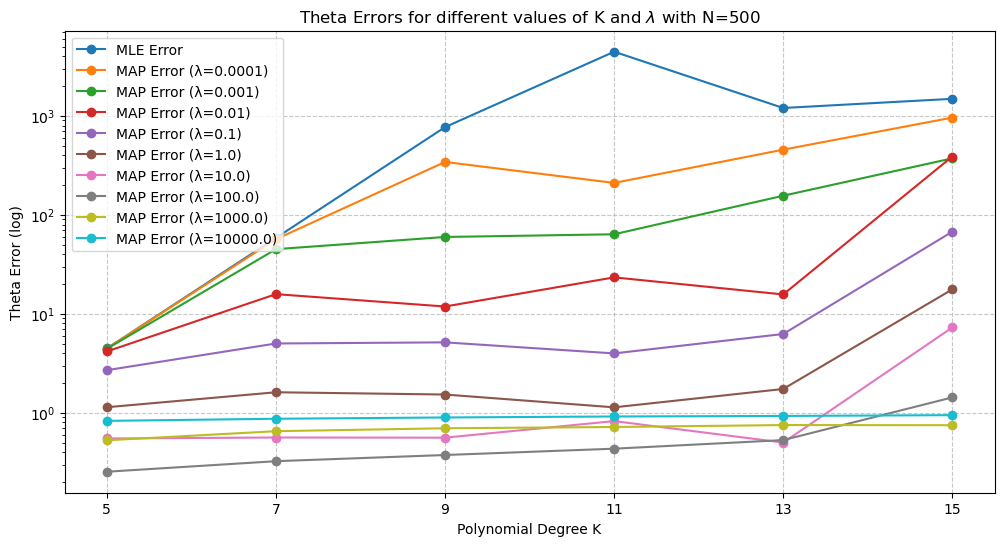

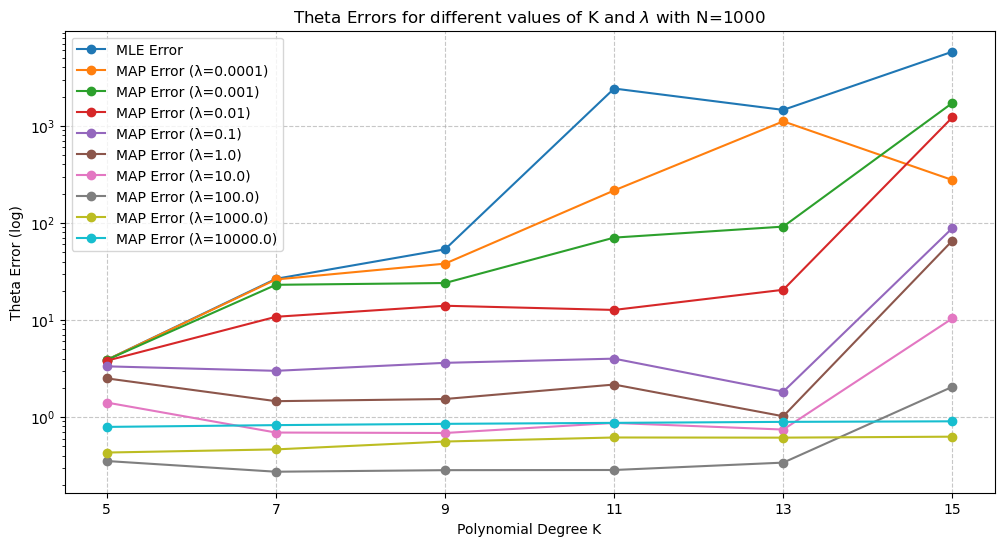

In [657]:
for N in N_values:
    (X_train, Y_train), theta_true = make_dataset(K_true, N, a, b, sigma_train, seed)
    for optimizer in [Optimizer.NORMAL_EQUATIONS]:
        mle_theta_errors = []
        map_theta_errors = [[] for _ in lambda_values]
        for K in K_greater_values:
            mle_model = MLE_Regressor(K, optimizer).fit(X_train, Y_train)
            mle_theta_errors.append(mle_model.err(theta_true))
    
            for i, lmb in enumerate(lambda_values):
                map_model = MAP_Regressor(K, optimizer, lmb).fit(X_train, Y_train)
                map_theta_errors[i].append(map_model.err(theta_true))
    
        plot_theta_errors(K_greater_values, mle_theta_errors, map_theta_errors, lambda_values, N)